In [1]:
from keras.layers import InputLayer, Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.models import Sequential
from keras.preprocessing.image import img_to_array, array_to_img, load_img, ImageDataGenerator
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave
import tensorflow as tf
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2

!rm -rf .DS_Store sample_data
!ls -la

Using TensorFlow backend.


total 16
drwxr-xr-x 1 root root 4096 Nov 13 05:55 .
drwxr-xr-x 1 root root 4096 Nov 13 05:50 ..
drwxr-xr-x 4 root root 4096 Nov  9 18:46 .config


In [0]:
TRAIN_SET = 'images/Train'
TEST_SET = 'images/Test'
EPOCHS = 5
COMPRESSED = '/content/gdrive/My Drive/datalab/dataset.tar'
BATCH_SIZE = 50

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
#!wget -O dataset.tar https://www.floydhub.com/api/v1/download/artifacts/data/MiXqoqaWLFhA5TNjJCiwoQ?is_dir=true&path=images
!tar -xvf '/content/gdrive/My Drive/datalab/dataset.tar'
# !rm -rf inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5 

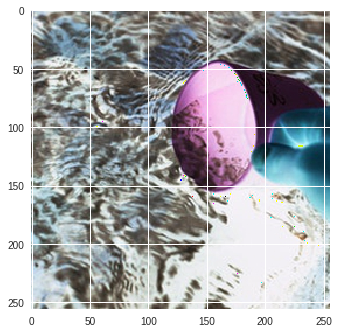

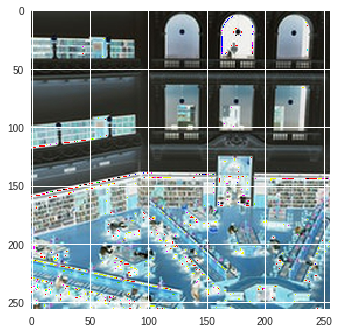

(1000, 256, 256, 3)


In [5]:
X = []
for idx, file in enumerate(os.listdir(TRAIN_SET)):
  img = img_to_array(load_img(os.path.join(TRAIN_SET, file)))
  X.append(np.array(img, dtype=np.float64))
  if idx == 999:
    break

for img in X[:2]:
  plt.imshow(img)
  plt.show()
X = np.array(X, np.float64)
# X = np.reshape(X, (1001, 256, 256, 3))
print(X.shape)


In [0]:
!rm -rf images testdata

In [0]:
model = Sequential()
model.add(InputLayer(input_shape=(256, 256, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

In [0]:
data_generator = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True, rescale=1.0/255)
def image_a_b_gen():
  ret = []
  for batch in data_generator.flow(x=X, batch_size=50):
    lab_batch = rgb2lab(batch)
    X_batch = lab_batch[:,:,:,0]
    Y_batch = lab_batch[:,:,:,1:] / 128
    bs = np.size(X_batch, 0)
    X_batch = np.reshape(X_batch, (bs, 256, 256, 1))
    Y_batch = np.reshape(Y_batch, (bs, 256, 256, 2))
    yield(X_batch, Y_batch)

In [0]:
model.compile(optimizer='adam', loss='mse')

In [0]:
model.fit_generator(image_a_b_gen(), steps_per_epoch=20, epochs=EPOCHS)

Epoch 1/5
17/20 [========================>.....] - ETA: 3:05 - loss: 0.1622

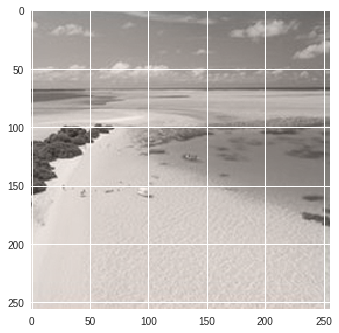

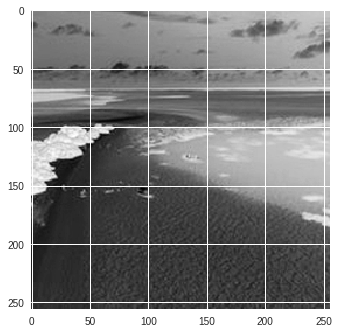

In [13]:
X_test = rgb2lab(1.0/255 * X[1])[:, :, 0]
y_test = rgb2lab(1.0/255 * X[1])[:, :, 1:]
X_test = np.reshape(X_test, (1, 256, 256, 1))
y_test = np.reshape(y_test, (1, 256, 256, 2))
out = model.predict(X_test) * 128
# print(X_test.shape, out.shape)
res = lab2rgb(np.concatenate([X_test, out], axis=-1)[0])
plt.imshow(res)
plt.show()
plt.imshow(rgb2gray(X[1]))
plt.show()